# How a Transformer Computes the Cumulative Sum Sign
**Author:** Dan Wilhelm [dan@danwilhelm.com]

We investigate how a one-layer attention+feed-forward transformer computes the cumulative sum. I've written the investigation conversationally, providing numerous examples and insights.

Of particular interest, we:
1. design a 38-weight attention-only circuit with smaller loss than the provided model;
2. prove that an equally-attended attention block is equivalent to a single linear projection (of the prior-input mean!); and
3. provide an independent transformer implementation to make it easier to modify the internals.

This is my proposed solution to a monthly puzzle authored by Callum McDougall! You may find more information about the challenge and monthly problem series here:
- [Problem GitHub page](https://github.com/callummcdougall/ARENA_2.0/tree/main/chapter1_transformers/exercises/monthly_algorithmic_problems/november23_cumsum)
- [ARENA page](https://arena-ch1-transformers.streamlit.app/Monthly_Algorithmic_Problems)
- [eindex dependency (needed to run the provided model)](https://github.com/callummcdougall/eindex/tree/main)


## Table of Contents
0. [Introduction](#intro)
1. [All 24 embedding channels directly encode token sign and magnitude](#embeds)
2. [Attention softmax equally attends to each token](#softmax)
3. [Equally-divided attention computes the expanding mean](#mean)
4. [Feed-forward network "cleans up" the signal](#ffn)
5. [What about the zero unembed pattern?](#unembeds)
6. [Surgically removing the MLP, retaining 100% accuracy](#removal)
7. [Designing a 38-weight attention-only cumsum circuit](#newnet)
8. [Appendix A. Rewriting two linear transforms as one](#proof)
9. [Appendix B. Designing a 38-weight circuit with skip connections](#skip)

# Introduction<a class="anchor" id="intro"></a>

## The Problem

- We are given a sequence $S$ of integers between -5 and 5, inclusive, where $|S| \le 20$.

- For each index $i$, we must determine whether the cumulative sum $S_{\leq i}$ is positive, zero, or negative.

- This can be accomplished by simply summing the subsequence and testing the resulting sign.

## Mechanism

It makes sense to hypothesize a solution is feasible. After all, transformers provide us with:

1. Dot products -- perfect for summing together numbers, and 
2. Pattern detectors -- perfect to detect positive/negative/zero.

We will prove below that the network works as follows:

1. **Embedding.** The magnitude and sign of each integer is directly encoded into each of the 24 embedding channels.
2. **Attention.** Each prior token is equally attended to. In this special case, the attention block outputs a linear combination of the _mean_ of the prior inputs.
3. **Feed-forward.** A few residual stream signs might be slightly incorrect due to noise*. So, these are error-corrected and boosted to ensure an exact unembed pattern match.
3. **Unembedding.** Now that the sign-corrected mean is on the residual stream, we compare its sign to positive/negative/zero patterns.

\* Substantial noise is introduced by non-zero biases, imperfectly linear embeddings, non-zero positional embeddings, the summed prior residual stream value, and inherent error in the weights.

We will later use our learnings by accomplishing the same with a simple 39-weight network (using a two-dimensional embedding and no MLP sub-block).

## What does the residual stream represent?

Transformers often represent information differently at various points in the residual stream. In this particular circuit, each channel stores nearly-identical information but with a different proportionality and sign. In fact, it is quite useful to consider each channel as storing separately a magnitude and sign. There are two overall spaces -- the embedding space and the post-attention/unembedding space.

1. **Embedding.** Initially, the magnitude and sign of each token is stored directly. The input token's sign is matched in channels 0, 1, 4, 8, 12, 13, 14, 15, 16, 17, 19, 21, and 23; the other channels have opposite sign.
2. **Post-Attention.** Each channel's magnitude now contains a scaled mean of the prior embeddings. However, the attention projections deterministically flip the sign of each channel. Now, the mean's sign is matched in channels 0, 1, 9, 12, 13, 14, 15, 17, 18, 19, 20, and 23; the other channels have opposing sign.
3. **Post-Feedforward.** The feedforward network outputs nearly exactly what it matches (yet larger-magnitude). So, signs are retained.
3. **Unembedding.** The three unembedding patterns (neg/zero/pos) identically match the signs outputted by the attention and MLP sub-blocks.

## What about zero?

We just discussed how positive and negative are represented by particular channels having particular signs at particular places in the network.

However, zero is primarily represented by small magnitudes. These small magnitudes lead to small activations, which make the attention and feedforward biases more prominent. The signs of these biases then near-perfectly match the signs of the "zero" pattern in the unembedding stage. This perhaps is similar to how logistic regression has an underlying "reference case" whose frequency is encoded in the bias.

What about in the feedforward stage? The "zero" pattern shares ~half of the signs with each positive and negative embed pattern. So, it slightly activates all of the feedforward network's hidden neurons, resulting in the output being the ~mean of all pos/neg outputs -- which is close to zero per channel.

# Initialization

In [1]:
from cumsum_model import CumsumModel
from cumsum_utils import where, rowplot, listplot, hline, vline, scatter
from transformer_lens import HookedTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import torch as t
from pathlib import Path
from eindex import eindex

# Make sure exercises are in the path
#chapter = r"chapter1_transformers"
#exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = "./monthly_algorithmic_problems/november23_cumsum"
#if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.november23_cumsum.dataset import CumsumDataset
from monthly_algorithmic_problems.november23_cumsum.model import create_model
from monthly_algorithmic_problems.plotly_utils import hist, bar, imshow

def fix_dataset(dataset: CumsumDataset):
    dataset.toks += dataset.max_value

def fix_model(model: HookedTransformer):
    max_value = model.W_E.shape[0] // 2
    model.embed.W_E.data = t.concat([model.W_E[-max_value:], model.W_E[:-max_value]])

device = "cpu"

In [2]:
# Load given model from disk
filename = section_dir + "/cumsum_model.pt"

model = create_model(
    max_value=5,
    seq_len=20,
    seed=0,
    d_model=24,
    d_head=12,
    n_layers=1,
    n_heads=1,
    normalization_type=None,
    d_mlp=8,
    device=device
)

state_dict = t.load(filename)

state_dict = model.center_writing_weights(t.load(filename))
state_dict = model.center_unembed(state_dict)
state_dict = model.fold_value_biases(state_dict)
model.load_state_dict(state_dict, strict=False);
fix_model(model)

In [3]:
def test_actual(model, dataset):
    'Display overall stats of given model on test dataset'
    logits, cache = model.run_with_cache(dataset.toks)

    logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
    probs = logprobs.softmax(-1)

    batch_size, seq_len = dataset.toks.shape
    logprobs_correct = eindex(logprobs, dataset.labels, "batch seq [batch seq]")
    probs_correct = eindex(probs, dataset.labels, "batch seq [batch seq]")

    print(f"Average cross entropy loss: {-logprobs_correct.mean().item():.3f}")
    print(f"Mean probability on correct label: {probs_correct.mean():.3f}")
    print(f"Median probability on correct label: {probs_correct.median():.3f}")
    print(f"Min probability on correct label: {probs_correct.min():.3f}")


def test_impl(model, dataset, **run_args):
    'Display overall stats of independent model on test dataset'
    probs_correct = np.zeros((len(dataset), len(dataset[0][0])))
    logprobs_correct = np.zeros_like(probs_correct)

    # Run each input through the model
    total_incorrect = 0
    for i,(X,y_true) in enumerate(dataset):
        X = X.cpu().numpy(); y_true = y_true.cpu().numpy()
        model.run(X, **run_args)
        if np.any(y_true != model.labels):               # Display any mislabelings
            print('INCORRECT RESULT:', model.toks_in, y_true, model.labels)
            total_incorrect += 1

        probs_correct[i] = np.choose(y_true, model.probs.T)       # Store only the probability of the "correct" class
        logprobs_correct[i] = np.choose(y_true, model.logprobs.T)

    print(f"Average cross entropy loss: {-np.mean(logprobs_correct):.3f}")
    print(f"Mean probability on correct label: {np.mean(probs_correct):.3f}")
    print(f"Median probability on correct label: {np.median(probs_correct):.3f}")
    print(f"Min probability on correct label: {np.min(probs_correct):.3f}")
    print(f"Incorrect labels:", total_incorrect)

In [4]:
# Verify that the given model and our independent implementation perform identically

N = 1000
dataset = CumsumDataset(size=N, max_value=5, seq_len=20, seed=np.random.randint(10000)).to(device); fix_dataset(dataset)  # 
m = CumsumModel(state_dict)

# Actual vs independent implementations - should see identical numbers
print('Original model:')
test_actual(model, dataset); print()

print('Numpy implementation w/ same weights (numbers should be identical):');
test_impl(m, dataset)

Original model:
Average cross entropy loss: 0.076
Mean probability on correct label: 0.936
Median probability on correct label: 0.999
Min probability on correct label: 0.550

Numpy implementation w/ same weights (numbers should be identical):
Average cross entropy loss: 0.076
Mean probability on correct label: 0.936
Median probability on correct label: 0.999
Min probability on correct label: 0.550
Incorrect labels: 0


# 1. All 24 embedding channels directly encode token sign and magnitude<a class="anchor" id="embeds"></a>

**Integer Embeddings.**
By graphing the input token embeddings below, we observe:
1. Each embed channel increases ~linearly with magnitude. So, +5/-5 have the largest magnitude and 0 the smallest.
2. 13/25 of the channels ~encode positive tokens positively and negative tokens negatively. The other 12/25 channels ~encode the opposite.
3. 0 and -1 are encoded with the most potential errors.

**Positional Embeddings.**
We know for this problem that positional embeddings have no effect and should be considered noise.
1. The mean positional embedding (across channels) is exactly zero.
2. The magnitude of the positional embeds are approximately the same as the magnitude of the "zero" embedding.

embed channels encoding +5 positively: [ 0  1  4  8 12 13 14 15 16 17 19 21 23]
embed channels encoding +5 negatively: [ 2  3  5  6  7  9 10 11 18 20 22]
positional embeddings average to zero per position: [ 0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0.  0.  0. -0. -0.  0.]


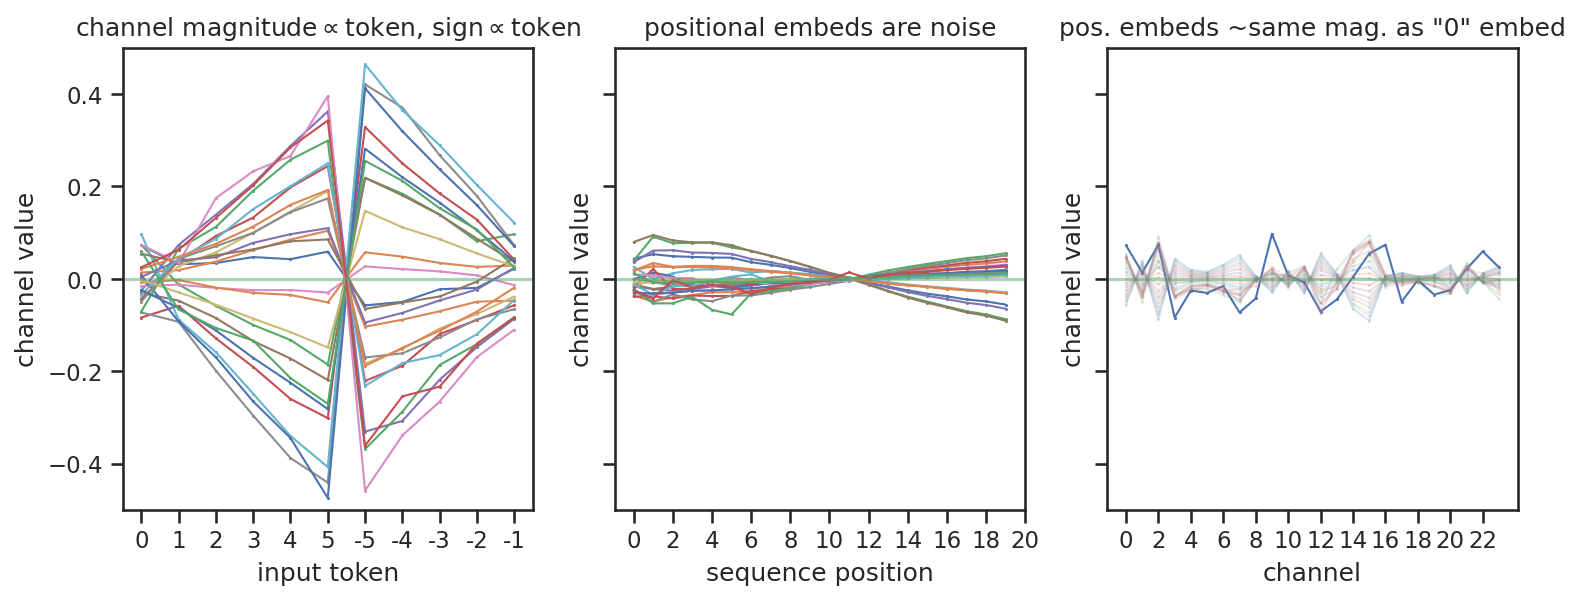

In [5]:
print('embed channels encoding +5 positively:', where(m.embeds[5] >= 0))
print('embed channels encoding +5 negatively:', where(m.embeds[5] < 0))
print('positional embeddings average to zero per position:', m.pos_embeds.mean(axis=1))

rowplot([
    [lambda: listplot(m.embeds.T, line=True, ylim=[-0.5,0.5], h=0, 
                      title='channel magnitude$\propto$token, sign$\propto$token', xlabel='input token', ylabel='channel value'),
     lambda: plt.xticks(np.arange(0, m.n_vocab, 1), m.embed_labels)],

    [lambda: listplot(m.pos_embeds.T, line=True, h=0, 
                      title='positional embeds are noise', xlabel='sequence position', ylabel='channel value'),
     lambda: plt.xticks(np.arange(0, m.seq_len+1, 2))],

    [lambda: listplot([m.embeds[0]], line=True, 
                      title='pos. embeds ~same mag. as "0" embed', xlabel='channel', ylabel='channel value'),
     lambda: listplot(m.pos_embeds, line=True, alpha=0.2, h=0),
     lambda: plt.xticks(np.arange(0, m.d_embd, 2))]
], sharey=True);

So, the sign and magnitude of each input token is directly preserved in the embeddings.

# 2. Attention softmax equally attends to each token<a class="anchor" id="softmax"></a>

We demonstrate this by showing the attention pattern matrix and working backward.

- Note the values are equal across each row, i.e. row $r$ attends to each with weight $1/r$.


In [6]:
m.attn_pattern[:10,:10]

array([[1.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.5000957 , 0.49990422, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.33337894, 0.33330205, 0.333319  , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.24997385, 0.2500293 , 0.25001684, 0.24998005, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.20001589, 0.1999849 , 0.19999169, 0.20001222, 0.19999528, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.16666096, 0.16667287, 0.16667014, 0.16666223, 0.16666889, 0.16666487, 0.        , 0.        , 0.        , 0.        ],
       [0.14286284, 0.14285149, 0.14285393, 0.14286143, 0.14285529, 0.14285898, 0.14285603, 0.        , 0.        , 0.        ],
       [0.12502673, 0.12497876, 0.12498938, 0.12502114, 0.12499483, 0.12501064, 0.12499941, 0.124

This is achieved by the attention projections having very small weights without outliers. The input stream is also bounded by the original embeddings and doesn't contain outliers.
- So, we get a situation where small_number * sum(small_numbers * small_numbers) ~= 0.
- To apply the softmax to the results, we exponentiate them: e^(small_number) ~= 1.
- And since every exponentiation has the same value 1, the softmax evenly attends to each token, with a weight $1/\text{ntokens}$ .

In [7]:
# quick demo using the existing model showing every pre-softmax is near-zero before the softmax.
# notice that the same token (in the index) has ~same exponentiation. They are slightly different only due to the positional embedding

pd.DataFrame(m.attn_q @ m.attn_k.T, index=m.toks_in)  # Columns are prior-sequence position, rows are the current token (will mask out the upper-right triangle)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-5,-0.00058750,0.00044789,0.00021604,-0.00047092,0.00010168,-0.00024234,-0.00001651,0.00045061,-0.00001614,0.00033730,0.00033903,-0.00001194,-0.00057918,-0.00001032,0.00034260,-0.00011925,-0.00046045,0.00023012,-0.00011706,0.00046283
4,0.00072761,-0.00059921,-0.00030583,0.00057296,-0.00015492,0.00028220,-0.00002795,-0.00058904,-0.00002192,-0.00044098,-0.00043965,-0.00001687,0.00074000,-0.00001037,-0.00042865,0.00015262,0.00060165,-0.00027721,0.00015813,-0.00056354
2,0.00043371,-0.00036521,-0.00018920,0.00033968,-0.00009758,0.00016498,-0.00002539,-0.00035670,-0.00002063,-0.00026705,-0.00026563,-0.00001577,0.00044520,-0.00001036,-0.00025630,0.00009187,0.00036430,-0.00016383,0.00009664,-0.00033417
-4,-0.00043859,0.00032932,0.00015695,-0.00035271,0.00007262,-0.00018294,-0.00001780,0.00033289,-0.00001680,0.00024918,0.00025086,-0.00001250,-0.00042981,-0.00001033,0.00025527,-0.00008847,-0.00034019,0.00017267,-0.00008590,0.00034661
1,0.00028788,-0.00024910,-0.00013133,0.00022393,-0.00006912,0.00010681,-0.00002412,-0.00024141,-0.00001999,-0.00018074,-0.00017928,-0.00001522,0.00029891,-0.00001035,-0.00017077,0.00006172,0.00024652,-0.00010758,0.00006612,-0.00022036
-2,-0.00014863,0.00009845,0.00004188,-0.00012256,0.00001604,-0.00006729,-0.00002033,0.00010366,-0.00001807,0.00007758,0.00007917,-0.00001359,-0.00013895,-0.00001034,0.00008522,-0.00002852,-0.00010601,0.00006081,-0.00002522,0.00012031
0,0.00014203,-0.00013297,-0.00007346,0.00010815,-0.00004067,0.00004864,-0.00002286,-0.00012612,-0.00001935,-0.00009443,-0.00009292,-0.00001468,0.00015261,-0.00001035,-0.00008524,0.00003157,0.00012873,-0.00005131,0.00003560,-0.00010653
4,0.00072890,-0.00060025,-0.00030635,0.00057399,-0.00015518,0.00028271,-0.00002797,-0.00059007,-0.00002193,-0.00044174,-0.00044041,-0.00001688,0.00074130,-0.00001037,-0.00042941,0.00015289,0.00060270,-0.00027771,0.00015841,-0.00056455
0,0.00014151,-0.00013257,-0.00007326,0.00010774,-0.00004057,0.00004843,-0.00002286,-0.00012571,-0.00001935,-0.00009413,-0.00009262,-0.00001468,0.00015210,-0.00001035,-0.00008494,0.00003146,0.00012832,-0.00005111,0.00003549,-0.00010612
3,0.00058439,-0.00048519,-0.00024900,0.00045928,-0.00012698,0.00022507,-0.00002671,-0.00047583,-0.00002130,-0.00035623,-0.00035485,-0.00001634,0.00059635,-0.00001037,-0.00034467,0.00012302,0.00048599,-0.00022196,0.00012817,-0.00045177


There are only eleven tokens and a max of 20 positions. So, we can computationally verify for each (token embed + positional embed) that the result is nearly one.

In [8]:
# Attempt every possible embed + positional embedding that could go into the softmax
# If they are all nearby 0, the softmax will divide them all equally resulting in ~1/ntokens
# (Notice above that the same token has ~same value pre-softmax -- different only due to the positional embedding!)
# So we wonder: How far is the farthest from 0? (e^0 == 1)
max_dist = 0.0
for embed in m.embeds:
    for pos_embed in m.pos_embeds:
        stream_in = embed + pos_embed
        attn_q = stream_in @ m.attn_wq + m.attn_bq    # q projection -- (toks,24) @ (24,12) => (toks,12)
        attn_k = stream_in @ m.attn_wk + m.attn_bk    # k projection -- (toks,24) @ (24,12) => (toks,12)
        
        # how close q projection matches k projection -- all ~0
        # next we would normally apply a mask then exponentiate for softmax!
        matches = attn_q @ attn_k.T / np.sqrt(m.d_head)   # 
        max_dist = max(max_dist, abs(matches))            # find farthest dist from 0

print('largest distance from 0:', max_dist)

largest distance from 0: 0.0002568125641409073


Therefore, we have proven that for every possible input, the attention attends equally to each prior token. Again, this is primarily because there are no outlier input embeddings or weights, and the projection matrices are entirely nearly zero.

# 3. Equally-divided attention computes the expanding mean<a class="anchor" id="mean"></a>

We've shown that the attention block equally attends to each prior input.

**Conceptually:**
- In this special case, we claim that each channel output can be rewritten as a linear combination of the prior-input means $\bar{x}_{\leq t}$.

- This stems from two things:
    1. It is well-known that two linear projections can be rewritten as a single linear projection*. For example, this is why neural nets require non-linear activations.
    2. The mean _is_ summing all previous elements, each divided by the number of elements (i.e. equally attending to them).

**More formally, we claim:**
> Given token index $t$, output channel position $p$, and input mean $\bar{x}_{\leq t}$, the attention output $a$ is given by:
> 
> $$ a_{t,p} = \mathbf{\overline{x}_{\leq t}} \cdot \mathbf{c_p} + b_p,$$
> 
> for a $k$-dimensional embedding and $k\text{x}k$ coefficients $\mathbf{C}$ (with biases $\mathbf{b}$ and row $\mathbf{c_p}$).

> Given an $h$-dimensional head, these are computed from the $k\text{x}h$ value projection weights $\mathbf{V}$ (with $1\text{x}h$ biases $\mathbf{b_v}$) and $h\text{x}k$ output projection weights $\mathbf{O}$ (with $1\text{x}k$ biases $\mathbf{b_o}$) as follows*:
>
> $$
\begin{align}
\mathbf{C} = && (\mathbf{V}\mathbf{O})^T\\
\mathbf{b} = && \mathbf{b_v}\mathbf{O} + \mathbf{b_o}
\end{align}
$$

\* For a derivation of these values (i.e. how to combine two linear projections into one), see [Appendix A](#proof).

---
#### The expanding mean is directly stored on the residual stream!

Let's show this visually:

input tokens: [ 1  2  3  0  0  0  0 -5 -1 -2 -3  0  0  0  0  5  5  5  0  0]
input token expanding mean: [ 1.          1.5         2.          1.5         1.2         1.          0.85714286  0.125       0.         -0.2        -0.45454545
 -0.41666667 -0.38461538 -0.35714286 -0.33333333  0.          0.29411765  0.55555556  0.52631579  0.5       ]


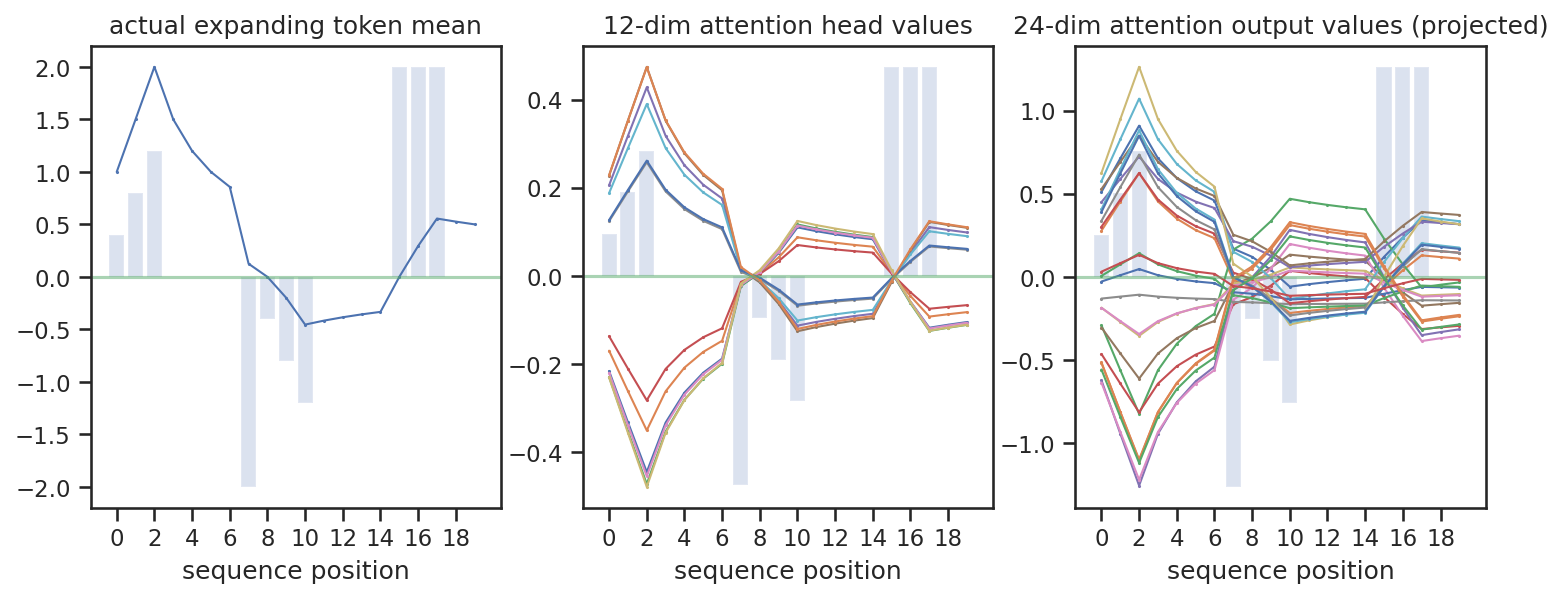

In [9]:
# Play around with the input values to better understand the expanding mean!
# Do you see that each of the 24-dim outputs are a linearly-transformed expanding mean?
# The sharply-decreasing slope is a property of the mean, since we divide by 2 then 3 then 4 ... (yielding x*0.5, x*0.3, x*0.25)

#               0  1  2  3  4  5  6   7   8   9  10 11 12 13 14 15 16 17 18 19
m.run(np.array([1, 2, 3, 0, 0, 0, 0, -5, -1, -2, -3, 0, 0, 0, 0, 5, 5, 5, 0, 0]) + m.max_value) # +max_value needed for compatibility w/ Dataset
#m.run(np.array([-1, -1, 3, -1, -2, 2, 0, 0, -5, -4, 0, 4, -2, -5, 0, -5, -4, -3, -1, -3]) + m.max_value)

expanding_token_mean = np.cumsum(m.toks_in) / np.arange(1,m.n_toks_in+1)
print('input tokens:', m.toks_in);
print('input token expanding mean:', expanding_token_mean);

rowplot([
    [lambda: listplot(expanding_token_mean, line=True, h=0,
                      title='actual expanding token mean', xlabel='sequence position'),
     lambda: plt.xticks(np.arange(0, m.seq_len, 2)),
     lambda: plt.bar(range(len(m.toks_in)), np.max(expanding_token_mean)*m.toks_in/m.max_value, alpha=0.2)],

    [lambda: listplot(m.attn.T, line=True, h=0, 
                      title='12-dim attention head values', xlabel='sequence position'),
     lambda: plt.xticks(np.arange(0, m.seq_len, 2)),
     lambda: plt.bar(range(len(m.toks_in)), np.max(m.attn.T)*m.toks_in/m.max_value, alpha=0.2)],

    [lambda: listplot(m.attn_out.T, line=True, h=0, 
                      title='24-dim attention output values (projected)', xlabel='sequence position'),
     lambda: plt.xticks(np.arange(0, m.seq_len, 2)),
     lambda: plt.bar(range(len(m.toks_in)), np.max(m.attn_out.T)*m.toks_in/m.max_value, alpha=0.2)],
]);

### How the attention block computes the mean

It's useful to understand how the attention sub-block computes the mean.

In [Appendix A](#proof), we derive $\mathbf{C}$ and $\mathbf{b}$ below by assuming we are given only the first token in a sequence (token $1$). This allows us to combine two projections into one and directly compute the attention output $a$ for a given channel position $p$:

$$ a_{1,p} = \mathbf{x_{1}} \cdot \mathbf{c_p} + b_p.$$

However, this assumes there is only a single input token to attend to! If we add a second token, we must take into account the softmax values $s_1$ and $s_2$ which weight the attention as so:

$$ a_{2,p} = s_1 \cdot (\mathbf{x_{1}} \cdot \mathbf{c_p} + b_p) + s_2 \cdot (\mathbf{x_{2}} \cdot \mathbf{c_p} + b_p).$$

But if _all_ softmax values are $1/t$, then each term is equally weighted and the mean becomes apparent:

$$
\begin{align}
a_{2,p} = && (\mathbf{x_{1}} \cdot \mathbf{c_p} + b_p)/2 + (\mathbf{x_{2}} \cdot \mathbf{c_p} + b_p)/2\\
        = && (\mathbf{x_{1}}/2 + \mathbf{x_{2}}/2) \cdot \mathbf{c_p} + (b_p/2 + b_p/2)\\
        = && \mathbf{\overline{x}_{\leq 2}} \cdot \mathbf{c_p} + b_p.
\end{align}
$$

Generalizing this (left to the reader), we thereby obtain the original proposition:

$$a_{t,p} = \mathbf{\overline{x}_{\leq t}} \cdot \mathbf{c_p} + b_p.$$

Alternatively in matrix form, we can compute the complete attention output $\mathbf{A}$:

$$\mathbf{A} = \mathbf{\overline{X}_{\leq}}\mathbf{C^T} + \mathbf{b}.$$

> In other words: the entire attention block can be reduced to a single linear projection with respect to the mean of the prior tokens!

Let's demonstrate using these exact examples below:

In [10]:
# EXAMPLE applying the linear model manually (C = mha_coefs, b = mha_biases)
m.run(np.array([-3, -4, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 5, 5, 3, 0, 0]) + m.max_value)
print(m.toks_in)

# Compute C and b
mha_coefs = (m.attn_wv @ m.attn_wo).T             # rows=output pos (as a func of input pos)  (toks,toks) 
mha_biases = m.attn_bv @ m.attn_wo + m.attn_bo    # (d_embd,)

out_pos = 10
print('first tok, pos 0 (actual):', m.attn_out[0,out_pos])
print('                 (linear):', np.dot(m.attn_in[0], mha_coefs[out_pos]) + mha_biases[out_pos])
print('second tok, pos 1 (actual):', m.attn_out[1,out_pos])
print('                  (linear):', 0.5*np.dot(m.attn_in[0], mha_coefs[out_pos]) + 0.5*np.dot(m.attn_in[1], mha_coefs[out_pos]) + mha_biases[out_pos])


# *** For an arbitrary token and output position
tok = 8; out_pos = 5
out_val = np.dot(np.mean(m.attn_in[:tok+1], axis=0), mha_coefs[out_pos]) + mha_biases[out_pos]  # o_t,p = \bar{x_<=t} . c_p + b_p
print(f'tok {tok:2}, pos {out_pos:2} (actual):', m.attn_out[tok,out_pos])
print(f'               (linear):', out_val)

[-3 -4 -5  0  0  0  0  0  0  0  0  0  0  1  2  5  5  3  0  0]
first tok, pos 0 (actual): -0.32659882
                 (linear): -0.32659882
second tok, pos 1 (actual): -0.36305144
                  (linear): -0.3630519062280655
tok  8, pos  5 (actual): 0.40263212
               (linear): 0.40262118


In [11]:
# EXAMPLE matrix form
embed_means = np.cumsum(m.attn_in, axis=0) / np.arange(1,m.n_toks_in+1).reshape(-1,1)
attn_out = embed_means @ m.mha_coefs.T + m.mha_biases

assert np.all(np.isclose(attn_out, m.attn_out, atol=1e-3))  # Should see no output if all positions match!

# 4. Feed-forward network "cleans up" the signal<a class="anchor" id="ffn"></a>

Unfortunately, there are many sources of potential error coming into the multi-layer perceptron (MLP) sub-block. Substantial noise is introduced by the skip connections, non-zero biases, imperfectly linear embeddings, non-zero positional embeddings, the summed prior residual stream value, and inherent error in the weights.

We'll show below that exactly two patterns are outputted by the multi-head attention (MHA) sub-block, corresponding to a positive and negative mean. The MLP subsequently pattern-matches exactly these two patterns. Finally, the unembed matches the same patterns. You can see this directly by visualizing the weights below:

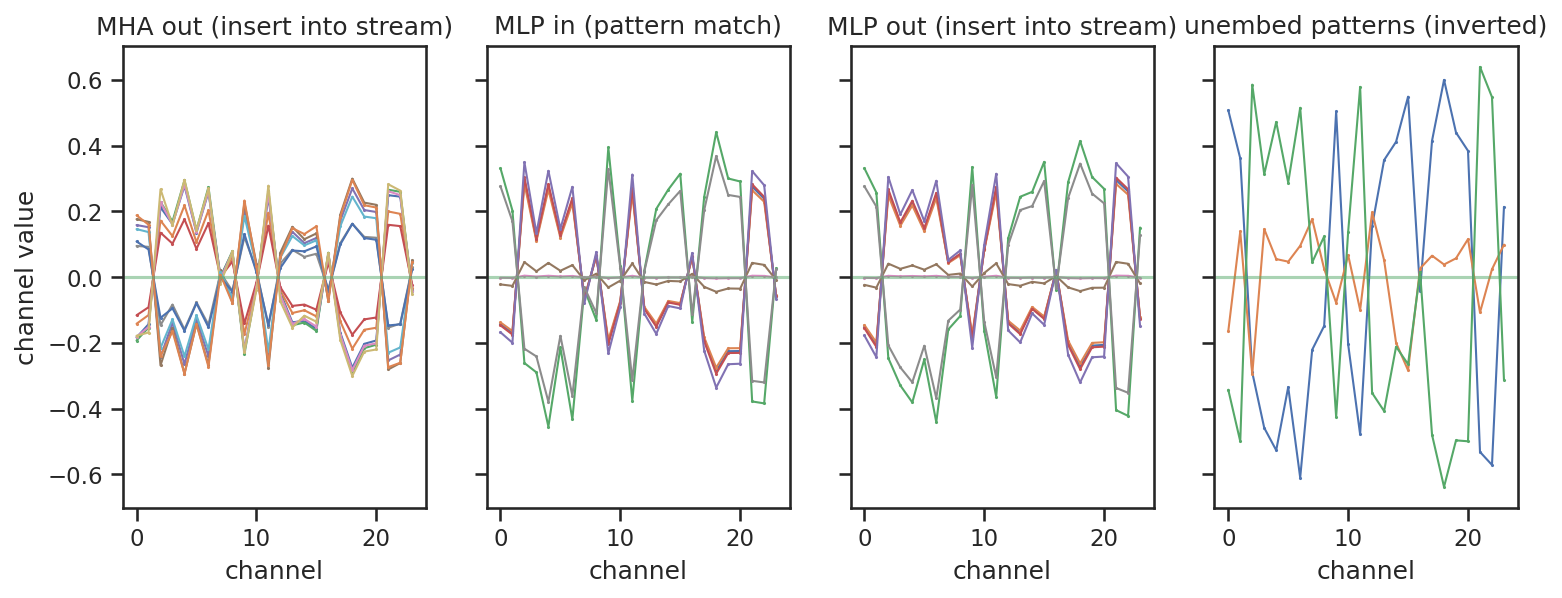

In [12]:
# Investigate what sign patterns are inserted into the stream (MHA out, MLP out) and pattern-matched from the stream (MLP in, unembed)
# - Note the MHA outputs patterns which are exactly detected by the MLP (left two graphs).
# - The MLP outputs near-identical patterns that it detects (middle two graphs -- each color has the same signs!)
# - The unembed patterns are nearly-identical to those outputted by the MHA and MLP, indicating this is the only other space stored in the residual stream.

# Note these are WEIGHTS, so the inputs don't matter
neg = np.array([0,1,3,4,5,6])
pos = np.array([2,7])
rowplot([
    [lambda: listplot(m.attn_wo, line=True, h=0, xlabel='channel', ylabel='channel value', title='MHA out (insert into stream)')],
    [lambda: listplot(m.mlp_win.T, line=True, h=0, xlabel='channel', title='MLP in (pattern match)')],
    [lambda: listplot(m.mlp_wout, line=True, h=0, xlabel='channel', title='MLP out (insert into stream)')],
    [lambda: listplot(-m.unembed_w.T, line=True, h=0, xlabel='channel', title='unembed patterns (inverted)')],
], sharey=True);

Let's visualize further why the MLP is a signal booster/error-corrector. It outputs near-exactly what it pattern matches, which we can directly see via the input vs. output weights:

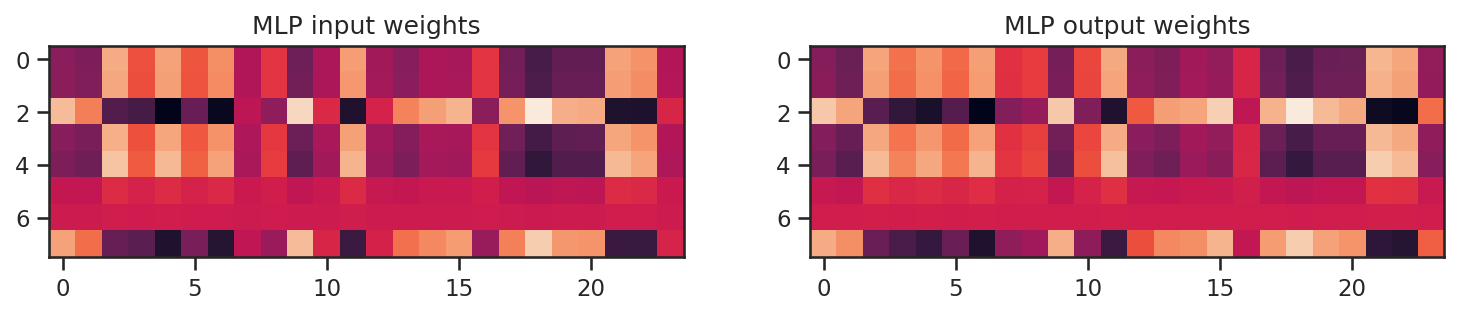

In [13]:
rowplot([
    [lambda: plt.imshow(m.mlp_win.T), lambda: plt.title('MLP input weights')],
    [lambda: plt.imshow(m.mlp_wout), lambda: plt.title('MLP output weights')],
]);

Recall that there is a RELU activation after the initial pattern match. RELU zeros out negative hidden outputs. So if a pattern does NOT match, the wrong pattern will NOT be outputted to the stream!

Because the input/output signs match nearly exactly, we can consider that the MLP **error-corrects** and **boosts** the attention output signal.

We can see directly that its output largely overwrites much of the residual stream, pushing values away from the boundary:

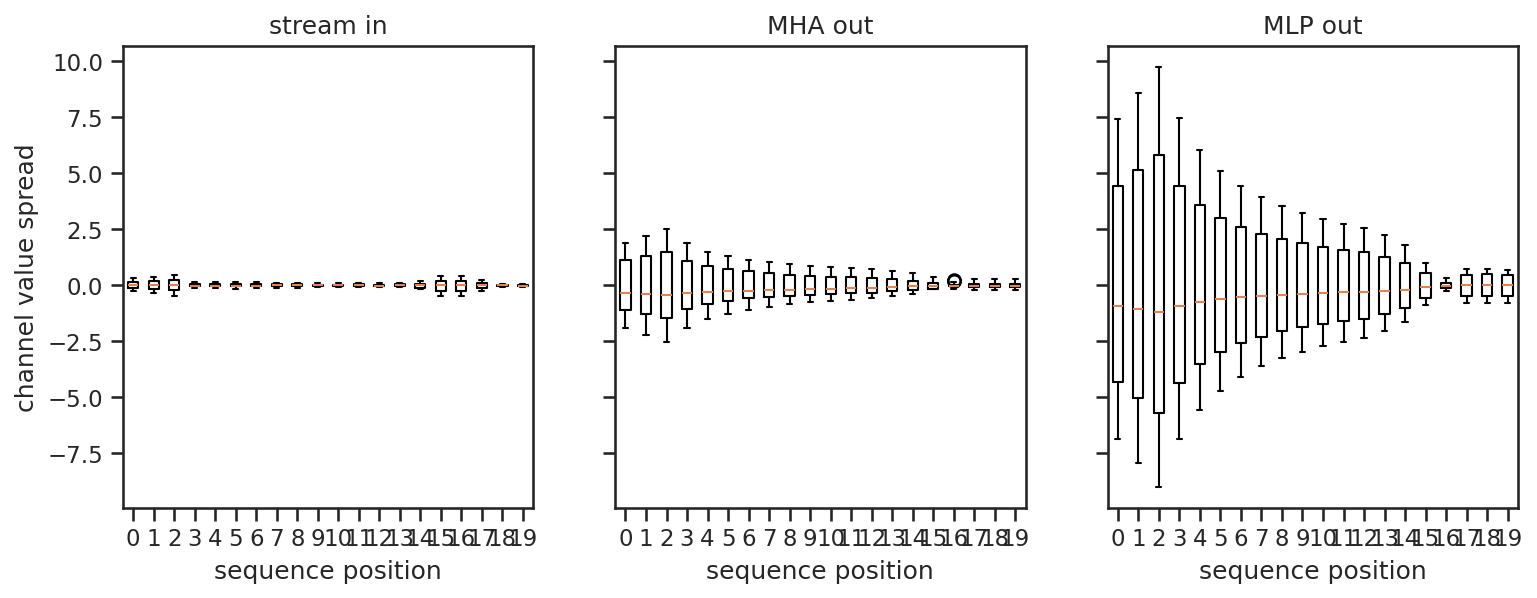

In [14]:
# Recall that the per-channel magnitude is proportional to the MEAN of the prior inputs
rowplot([
    [lambda: plt.boxplot(m.stream_in.T, labels=range(len(m.mlp_out))), 
     lambda: plt.title('stream in'), lambda: plt.xlabel('sequence position'), lambda: plt.ylabel('channel value spread')],
    [lambda: plt.boxplot(m.attn_out.T, labels=range(len(m.mlp_out))), 
     lambda: plt.title('MHA out'), lambda: plt.xlabel('sequence position')],
    [lambda: plt.boxplot(m.mlp_out.T, labels=range(len(m.mlp_out))),
     lambda: plt.title('MLP out'), lambda: plt.xlabel('sequence position')],
], sharey=True);

# 5. What about the zero unembed pattern?<a class="anchor" id="unembed"></a>

In the above graphs, the zero pattern is not outputted by MHA or detected/outputted by MLP. So, how can the zero pattern possibly be detected by the unembed?

It turns out that the "zero" pattern is encoded in the biases. This is analogous to how the "reference pattern" in logistic regression is encoded in the bias.

By plotting the "token 1" biases as computed in section 3 for the MHA and MLP (excluding RELU), we see they nearly-exactly encode the "zero" unembed pattern:

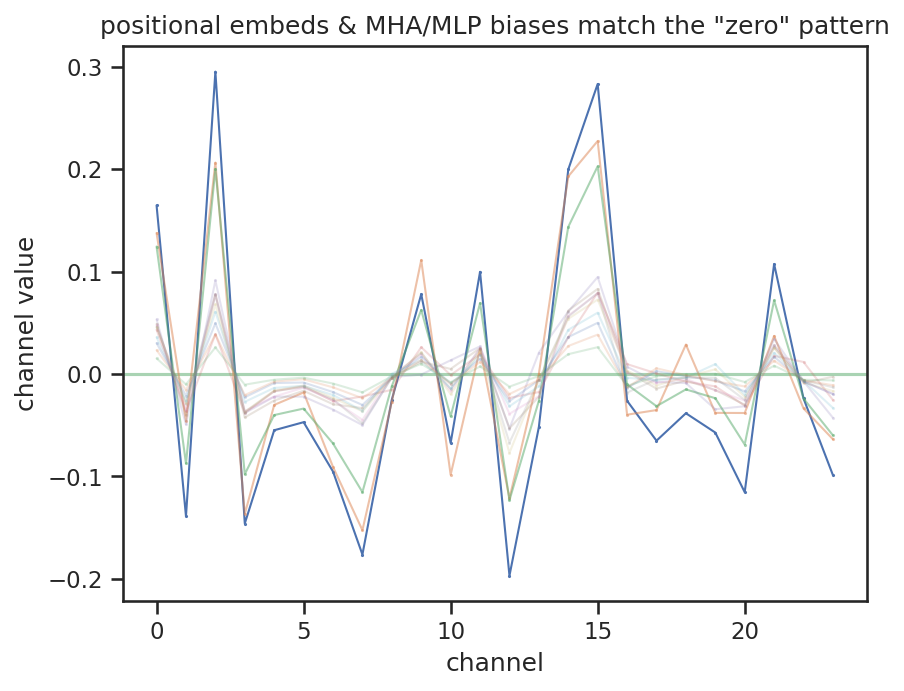

In [15]:
# The positional embeds and MHA/MLP biases -- as calculated in section 3 -- match the zero pattern
listplot([m.unembed_w[:,1]], line=True, h=0, 
         title='positional embeds & MHA/MLP biases match the "zero" pattern', xlabel='channel', ylabel='channel value')
listplot([m.mha_biases, m.ffn_biases], alpha=0.5, line=True)
listplot(m.pos_embeds[:10], alpha=0.2, line=True) # The final ten are opposite the zero pattern

However, for these biases to have a large impact, they must be accompanied by low-magnitude channel values.

For this to occur, the zero pattern signs ~half-match the positive and negative unembed pattern signs:

In [16]:
sunembed = np.sign(m.unembed_w).astype(int).T

print(f'# same-sign "zero" and "neg" (of {m.d_embd}):', np.sum(sunembed[1] == sunembed[0]))  # of 24
print(f'# same-sign "zero" and "pos" (of {m.d_embd}):', np.sum(sunembed[1] == sunembed[2]))  # of 24
print(f'# same-sign "pos" and "neg"  (of {m.d_embd}):', np.sum(sunembed[0] == sunembed[2]))  # of 24

# same-sign "zero" and "neg" (of 24): 11
# same-sign "zero" and "pos" (of 24): 13
# same-sign "pos" and "neg"  (of 24): 0


In the MLP, the zero pattern is neither directly matched nor outputted. However, a low-magnitude residual stream affected by the MHA biases (shown above) will match the positive and negative patterns weakly.

The pattern matching occurs due to the dot product:
- If the input signs match the weight signs, we obtain a large positive hidden neuron value.
- In the opposite case, we obtain a large negative hidden neuron value.
- As the input magnitude increases, the hidden neuron magnitudes also increase.
- If the input magnitudes are small, the hidden neuron magnitudes will also be small (but their sign will still indicate pattern match).

In the following, we observe the eight MLP neurons. Notice the "zero" labels all ~equally activate the neurons, while the "low positives" only activate _some_ of them:

In [17]:
# Notice the "zero" labels (starred) all ~equally activate the neurons, while the "positive" labels only activate some of them (others near zero/negative):
# - Recall that there are a ~equal number of opposite patterns, so this will bring the weights closeby zero.

m.run(np.array([5, -5, 3, 2, -5, -2, -1, 4, 5, 5, 5, 5, 5, 5, 5, 5]) + m.max_value)
print('  input tokens:', m.toks_in)
print('cumulative sum:', np.cumsum(m.toks_in))
print(' output labels:', m.labels)

print(); print('output label | MLP input sign | MLP hidden neuron values')
for i in range(m.n_toks_in):
    print('*' if m.labels[i] == 1 else ' ', end='')
    print(m.labels[i], np.sign(m.attn_out[i]).astype(int), m.hidden[i])


  input tokens: [ 5 -5  3  2 -5 -2 -1  4  5  5  5  5  5  5  5  5]
cumulative sum: [ 5  0  3  5  0 -2 -3  1  6 11 16 21 26 31 36 41]
 output labels: [2 1 2 2 1 0 0 2 2 2 2 2 2 2 2 2]

output label | MLP input sign | MLP hidden neuron values
 2 [ 1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1] [ -8.71235     -8.375496    14.529226    -8.930467   -10.2197075   -1.3556988   -0.12924725  12.124514  ]
*1 [ 1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1] [0.29371414 0.28247762 0.4900266  0.30153626 0.3439835  0.04571045 0.00463238 0.40809906]
 2 [ 1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1] [-1.486733   -1.4294275   3.2634277  -1.5237269  -1.7438643  -0.23114383 -0.02200314  2.7233865 ]
 2 [ 1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1] [-1.9517646  -1.8764291   3.988881   -2.0003762  -2.2894022  -0.30357832 -0.02887579  3.3286674 ]
*1 [ 1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1  1

In [18]:
# If we equally weight the outputs as a low-magnitude input would, we effectively zero out our weights
# This allows the bias to inch it toward the desired "zero" pattern's signs:
print('mean per-channel weights:', m.mlp_wout.mean(axis=0))
print('bias:', m.mlp_bout)

mean per-channel weights: [-0.00605019 -0.05313775  0.08372439  0.0123035   0.03481946  0.02095986  0.03404465 -0.01251634  0.01026748 -0.02236199  0.00795271
  0.06136047 -0.04760577 -0.03563061  0.00838158  0.01317514  0.00106885 -0.04273967 -0.05295373 -0.0429178  -0.05001276  0.06695439
  0.04433465 -0.03342056]
bias: [ 0.07362018 -0.05094207  0.11443717 -0.05684377 -0.02475116 -0.02076853 -0.04047872 -0.06660617 -0.00608693  0.03648141 -0.02414637
  0.03987577 -0.07000588 -0.01482397  0.08340748  0.11837593 -0.00453076 -0.01706066 -0.0075587  -0.01191136 -0.03955231  0.04105154
 -0.0161934  -0.03498874]


# 6. Surgically removing the MLP, retaining 100% accuracy<a class="anchor" id="removal"></a>

We know from above that each channel of the attention output contains a linear transformation of the mean.

So, we can readily guess that the MLP may not be needed. Especially so since the attention output seems to already be transformed into the unembedding space, as we saw above.

> Note this does _not_ include the skip connection. Since the residual stream now contains the mean, summing it with the original embed adds pure noise to the mean, obscuring it. We will mathematically build margins around this noise in the next section and [Appendix B](#skip).

Experimentally, we observe that indeed we can derive the correct labels exactly from the attention output:

```
        logit_2 >   0.00  =>   class 2   # overrides all others
        logit_0 <  -0.15  =>   class 1
        logit_0 >= -0.15  =>   class 0
```

We experimentally find that the sum of the three attention logits is always zero. Hence, they only have two degrees of freedom.

It seems that our training procedure has already segregated the information purely into logits 0 and 2. So, we just need to design a method for transforming the existing unembeds to these.

Recall that we compute each logit $l$ as $l_i = \mathbf{a} \cdot \mathbf{u_i} + \mathbf{u_b}$, where $\mathbf{U}$ are the unembedding weights and $\mathbf{u_b}$ the unembedding biases.

So, let's apply the above observations by modifying the unembeds as follows:

1. To ensure $l_2$ is largest when positive, we can simply scale it up and the others down. So, we experimentally multiply $\mathbf{u_2}$ by 5 and divide the others by 5.
2. We want to detect class 1 using logit 0, but in the opposite direction. So, we replace $\mathbf{u_1}$ and $u_{b,1}$ with the opposite sign of their respective class 0 unemebeddings.
3. To detect -0.15 as the boundary instead of 0, we must adjust the bias by adding 0.15 to the class 0 unembed bias.

All together, this is:

```python
        m.unembed_w[:,0] = m.unembed_w[:,0] / 5
        m.unembed_w[:,1] = -m.unembed_w[:,0]
        m.unembed_w[:,2] = 5 * m.unembed_w[:,2]         # Scaling ensures that if logit_2 > 0, class 2 is always selected.
        m.unembed_b[0] = (m.unembed_b[0] + 0.15) / 5    # If original logit_0 > -0.15, class 0 is selected.
        m.unembed_b[1] = -m.unembed_b[0]                # If original logit_0 < -0.15, class 1 is selected.
```

And you can try it out in the code below to see it appears to acheive 100% accuracy (but with worse loss):

In [19]:
# Test model 
N = 1000
dataset = CumsumDataset(size=N, max_value=5, seq_len=20, seed=np.random.randint(10000)).to(device); fix_dataset(dataset)

# Save original weights
old_unembed_w = m.unembed_w.copy()
old_unembed_b = m.unembed_b.copy()

# Modify unembeddings to recognize the attention output
m.unembed_w[:,0] = m.unembed_w[:,0] / 5
m.unembed_w[:,1] = -m.unembed_w[:,0]
m.unembed_w[:,2] = 5 * m.unembed_w[:,2]         # Scaling ensures that if logit_2 > 0, class 2 is always selected.
m.unembed_b[0] = (m.unembed_b[0] + 0.15) / 5    # If original logit_0 > -0.15, class 0 is selected.
m.unembed_b[1] = -m.unembed_b[0]                # If original logit_0 < -0.15, class 1 is selected.

# Run same tests as above, but without the MLP and skip connections
test_impl(m, dataset, use_mlp=False, use_attn_skip=False)

# Restore original weights
m.unembed_w = old_unembed_w
m.unembed_b = old_unembed_b

Average cross entropy loss: 0.312
Mean probability on correct label: 0.767
Median probability on correct label: 0.805
Min probability on correct label: 0.399
Incorrect labels: 0


# 7. Designing a 38-weight attention-only cumsum circuit<a class="anchor" id="newnet"></a>

### High-level explanation

We saw above that we can completely remove the MLP from our trained model. Can we possibly design an even more minimal attention-only circuit?

Pretend you only have two channels, and the integer $x$ is embedded as: $(x, -x)$.
- Your unembed weights encode three patterns -- positive: $(+1,-1)$, negative: $(-1,+1)$, and zero: $(+1,+1)$.
- If we immediately unembed the embed, we can detect pos/neg but not zero. Why? The dot product of (0, 0) with anything is zero.

So how do we get zero working? Before we unembed, we simply add $(0.1, 0.1)$. So an input of $(0, 0)$ becomes $(0.1, 0.1)$, which matches best with zero!
- Recall that to calculate the final logit, we take the dot product of the 2-dimensional stream and the unembed pattern.
- For example, the zero-class logit is: $(0.1, 0.1) * (+1, +1) = 0.2$, and the positive-class logit is: $(0.1, 0.1) * (+1, -1) = 0$.
- Since the zero-class logit is largest, "zero" is our predicted class for $(0, 0)$.

We are trying to determine whether the _cumulative sum_ is one of these classes. So, we need to add a step that computes the mean, then place the mean + 0.1 onto the residual stream.

Below, we will show how to set the $V$ and $O$ projection matrices to output $A = (\text{mean} + 0.1, -\text{mean} + 0.1)$ onto the residual stream.

So finally, we unembed. Assuming $A$ is on the residual stream, here are the final logits. The largest logit is the predicted class:

- $l_+ = A \cdot ( 1, -1) = 2 \cdot \text{mean}.$
- $l_- = A \cdot (-1,  1) = -2 \cdot \text{mean}.$
- $l_0 = A \cdot ( 1,  1) = 0.2.$

When the mean > 0, the positive-class logit is largest. When mean < 0, the negative-class logit largest. When mean = 0, the zero-class logit is largest.

----

Utilizing the principles above, now let's derive the 38-weights* in an attention-only circuit that implements the problem statement.

- We choose only two embed dimensions/channels and a single head neuron.
- Only attention is used, no MLP.
- We retain the 20-token sequence length and tokens from -5 to 5 inclusive.

\* Since positional embeddings, KQV-projection biases, and unembedding biases are zeroed out, they are not counted toward the weight total.

First, let's examine our minimal model's performance relative to the trained model:

In [20]:
N = 1000
dataset = CumsumDataset(size=N, max_value=5, seq_len=20, seed=np.random.randint(100000)).to(device); fix_dataset(dataset)
m2 = CumsumModel()  # loads attention-only circuit

# Actual vs independent implementations - should see identical numbers
print('Original model:')
test_actual(model, dataset); print()

print('Minimal attention-only model:')
test_impl(m2, dataset)

Original model:
Average cross entropy loss: 0.075
Mean probability on correct label: 0.937
Median probability on correct label: 0.999
Min probability on correct label: 0.568

Minimal attention-only model:
Average cross entropy loss: 0.026
Mean probability on correct label: 0.977
Median probability on correct label: 1.000
Min probability on correct label: 0.705
Incorrect labels: 0


This performs better in every metric! Yet, I challenge the reader to improve the model even more, since it has not been optimized.


In [21]:
# Try a particular example
m2.run(np.array([ 1, 2, 3, -5, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, -4, -1]) + m2.max_value)
print('input tokens:', m2.toks_in)
print('  out labels:', m2.labels); print()
print('class probabilities:\n', m2.probs)

input tokens: [ 1  2  3 -5  0  0  0 -1  0  1  0  0  0  0  0  5  0  0 -4 -1]
  out labels: [2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2]

class probabilities:
 [[0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.00000002 0.99999998]
 [0.         0.00000043 0.99999957]
 [0.         0.00000462 0.99999538]
 [0.12953422 0.78363639 0.08682939]
 [0.10650698 0.78698604 0.10650698]
 [0.         0.00027458 0.99972542]
 [0.00000001 0.00083195 0.99916804]
 [0.00000006 0.00177295 0.99822699]
 [0.00000021 0.00336047 0.99663932]
 [0.00000062 0.00580705 0.99419232]
 [0.0000016  0.00931594 0.99068245]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.00044087 0.99955912]
 [0.00006384 0.05732052 0.94261564]]


----
#### Overall design notes
- We set each 2-dimensional embedding to 1/100 and -1/100 of the token integer. This ensures perfect linearity, sign, and magnitude -- with zero noise.
    - For example, $\mathbf{e[5]} = (5/100, -5/100)$.
    - The scaling ensure numerical stability of the final log softmax.
    - The first dimension is the original sign, the second the opposite sign.
- The positional embeddings are set to zero, since we know position is irrelevant.
- As we showed earlier, making the K and Q projections have near-zero weights ensures the attention output is a linear combination of the input mean.
- At least two channels are required to detect three classes.
    - It isn't possible to select three classes from a single channel using a dot product.
    - If we tried, then two of the three unembeddings necessarily would have the same sign.
    - However, the larger-magnitude unembed would then always be predicted given a same-sign input, since its dot product would be larger!
- The unembedding patterns are based on the  sign of each channel.
    - We will choose the following mappings: +1/-1 => "positive", -1/+1 => "negative", +1/+1 => "zero".
    - Normally, we require the two channels to have opposite sign.
    - However, if the cumulative sum/mean is close to zero, the biases become pronounced. These will push both channels positive.
    - Therefore, we will select slightly positive output projection biases.

Now, let's choose the weights. Detecting "positive" versus "negative" is quite easy -- simply pattern match the first channel's sign! What is much more difficult is ensuring that "zero" is correctly detected. The plan is:
- First, we will select attention output projection weights that allow us to output +1/+1 biases when the mean is zero.
- Second, we will ensure that the "zero"-class logit is always a constant (not dependent on the embedding or prior tokens).
    - This logit acts as a fixed threshold for the "zero" class.
- Finally, we will select the remaining weights in a way that creates a margin between the "zero"-class logit when the mean is zero versus a minimal value.

---
#### Choosing the V and O projections

We decided above that the two embedding dimensions have opposite sign. So, the two dimensions of their mean also have opposite sign, i.e. $\overline{x}_{\leq t,1} = -\overline{x}_{\leq t,2}$.

To find good values for the $\mathbf{V} = (x, y)^T$ and $\mathbf{O} = (z, w)$ projections, we multiply out the attention output $\mathbf{A} = \mathbf{\overline{X}_{\leq}}\mathbf{C^T} + \mathbf{b}$ into two channels:

$$
\begin{align}
\left\{
\begin{array}{ll}
a_1 = && \overline{x}_{\leq t,1}(xz) + \overline{x}_{\leq t,2}(yz) + b_vz + b_{o,1}\\
a_2 = && \overline{x}_{\leq t,1}(xw) + \overline{x}_{\leq t,2}(yw) + b_vw + b_{o,2}\\
\end{array}
\right\}

\implies
\left\{
\begin{array}{ll}
a_1 = && \overline{x}_{\leq t} \cdot z(x - y) + b_vz + b_{o,1}\\
a_2 = && \overline{x}_{\leq t} \cdot z(x - y) + b_vw + b_{o,2}
\end{array}
\right\}.
\end{align}
$$

+ For simplicity, let's set $\mathbf{V} = (x,y)^T = (1,0)^T$. This allows us to scale each channel independently using $z$ and $w$.
+ Recall that we must give the two channels opposite sign, so we'll also set $z = -w$.
+ We already assumed that the KQV biases are zero, so $b_v = 0$.

That leaves us with:

$$
\begin{align}
\left\{
\begin{array}{ll}
a_1 = &&  z \cdot \overline{x}_{\leq t} + b_{o,1}\\
a_2 = && -z \cdot \overline{x}_{\leq t} + b_{o,2}
\end{array}
\right\}.
\end{align}
$$

If we set $1 > b_{o,1} = b_{o,2} > 0$ and $z = 1$, this solves the problem without a skip connection!

Here is why this solves the problem as-is:
+ When the mean is non-zero, the two output channels are ~opposite. So, unembeddings such as +1/-1 and -1/+1 will be maximized when the mean is positive and negative, respectively.
+ When the mean is zero, the both-positive biases become prominent. So, a third unembedding such as +1/+1 will be maximized, indicating our "zero" class.

----
#### Designing for skip connections (moved to [Appendix B](#skip))

Although the above solves the problem exactly, modern LLMs use skip connections. So, it would be interesting to gain additional insights designing a solution for that case as well.

> Why is a skip connection more difficult? Recall that each linear transform has the potential of projecting the residual stream into a different space. So, re-adding the input embedding adds a lot of noise to the attention output. In this case, the output is the mean of all prior tokens, and the noise is the current token's embedding. To get around this, we must ensure there are margins around the "zero"-class logit.

This will require careful design of the remaining weights -- which we accomplish in [Appendix B](#skip).

----
# Appendix A. Rewriting two linear transforms as one<a class="anchor" id="v"></a>

It is often useful to combine two linear projections into one. For example, in the MHA, the first token has only a single token to attend to! So, we simply project the input twice, by the value projection followed by the output projection. Because there is no non-linearity, we can combine these two projections into one.

**Theorem.** Suppose a single token is attended to, along with output channel position $p$. Then, the attention output $a$ is a linear combination of the input channels $\mathbf{x}$ and fixed coefficients $\mathbf{c}$ with biases $\mathbf{b}$:

$$ a_{t,p} = \mathbf{x} \cdot \mathbf{c_p} + b_p.$$

We can directly compute $\mathbf{c}$ and $\mathbf{b}$ from the value and output projections.

Suppose a single input which is completely attended to. Then, attention output $A$ is computed by the value projection followed by the output projection, i.e. $\mathbf{A} = (\mathbf{x}\mathbf{W} + \mathbf{b})\mathbf{V} + \mathbf{b'}$, where $\mathbf{x}$ is the $k$-element input vector, $n$ is the dimensionality of each attention head, $\mathbf{W}$ is the $k\text{x}n$ value projection matrix, and $\mathbf{V}$ is the $n\text{x}k$ output projection matrix (with biases $\mathbf{b}$ and $\mathbf{b'}$, respectively).

Any two back-to-back linear transforms can be simplified into a single linear transform. So, let $M$ represent the intermediate step $M = xW + b$. Then,

$$
\begin{align}
m_p = && b_p + \sum_{i=1}^{k}{w_{pi} \cdot x_i}\\
a_p = && b'_p + \sum_{j=1}^{n}{v_{jp} \cdot m_j}\\
\end{align}
$$

Simplifying $a$ to be in terms of the input $x$ and a bias:
$$
\begin{align}
a_p = && b'_p + \sum_{j=1}^{n}{v_{pj} \cdot \left(b_p + \sum_{i=1}^{k}{w_{pi} \cdot x_i}\right)}\\
    = && \sum_{i=1}^{k}{x_{i} \cdot \left(\sum_{j=1}^{n}{v_{jp} \cdot w_{pi}}\right)}  +  \left(\sum_{j=1}^{n}{b_j \cdot v_{jp}}  +  b'_p\right).\\
\end{align}
$$

This gives the desired $\mathbf{c}$ and $\mathbf{b}$ (each parenthesized above):
$$
\begin{align}
c_p = && \sum_{j=1}^{n}{v_{pj} \cdot w_{pi}}\\
b_p = && \sum_{j=1}^{n}{b_j*v_{jp}}  +  b'_p.\\
\end{align}
$$



Alternatively in matrix form (where $\mathbf{c_p}$ is a row of $\mathbf{C}$):

$$
\begin{align}
\mathbf{C} = && (\mathbf{V}\mathbf{O})^T\\
\mathbf{b} = && \mathbf{b_v}\mathbf{O} + \mathbf{b_o}
\end{align}
$$

----
# Appendix B. Designing a 38-weight circuit with skip connections<a class="anchor" id="skip"></a>


----
#### Making the "zero"-class logit a constant (w/ skip connection)
The idea is we want to set the "zero"-class logit to a fixed number, regardless of the input embedding. Then we can ensure margins on it so that any non-zero mean is above the margin.

To do this, we express the final "zero" logit in terms of the two output channels. To compute the logit, we sum the attention output with the current token embedding $\mathbf{e}$, then take its dot product with the unembeddings $\mathbf{u_{\textbf{zero}}}$. 
+ In the final simplifying step below, recall that our "zero" pattern is two positive signs. So we must let $u_{\textbf{zero},1} = u_{\textbf{zero},2} > 0$, which happens to cancel out the input embedding (since $e_1 = -e_2$ by design).

$$
\begin{align}
l_{\textbf{zero}} = && u_{\textbf{zero},1} \cdot a_1 + u_{\textbf{zero},2} \cdot a_2 + b_u\\
                  = && u_{\textbf{zero},1}\left(\overline{x}_{\leq t} \cdot z + b_{o,1} + e_1\right) + u_{\textbf{zero},2}\left(-\overline{x}_{\leq t} \cdot z + b_{o,2} + e_2\right) + b_u\\
                  = && z \cdot \overline{x}_{\leq t}\left(u_{\textbf{zero},1} - u_{\textbf{zero},2}\right) + (e_1 + b_{o,1}) \cdot u_{\textbf{zero},1} + (e_2 + b_{o,2}) \cdot u_{\textbf{zero},2} + b_u\\
                  = && (b_{o,1} + b_{o,2}) \cdot u_{\textbf{zero},1} + b_u.
\end{align}
$$

Hence regardless of the mean and input embedding, our "zero" logit will always have a fixed value solely based on the chosen weights!

----
> **Next, we must bound our "zero" logit threshold above and below, to ensure it has proper margins from the pos/neg classes.**

----
#### Lower bound. Ensure a zero mean is always below the "zero" logit threshold (w/ skip connection)

We must ensure that when the mean is zero, the logit $l_{\textbf{zero}} > \max{(l_{\textbf{pos}}, l_{\textbf{neg}})}$. We'll assume the negative unembeddings are the exact opposite of the positive ones to simplify the analysis, i.e. $u_{\textbf{pos}} = -u_{\textbf{neg}}$.

For the "positive" class, our unembed pattern requires $u_{\textbf{pos},1} > 0$ and $u_{\textbf{pos},2} < 0$. For simplicity, let's suppose $u_{\textbf{pos},1} = -u_{\textbf{pos},2}$ and $b_{o,1} = b_{o,2}$. Then we can directly compute the "positive"-class logit $l_{\textbf{pos}}$ (similarly to the $l_{\text{zero}}$ derivation above):

$$
\begin{align}
l_{\textbf{pos}} = && z \cdot \overline{x}_{\leq t}\left(u_{\textbf{pos},1} - u_{\textbf{pos},2}\right) + (e_1 + b_{o,1}) \cdot u_{\textbf{pos},1} + (e_2 + b_{o,2}) \cdot u_{\textbf{pos},2} + b_u\\
                 = && 2 \cdot (z \cdot \overline{x}_{\leq t} + e_1) \cdot u_{\textbf{pos},1} + b_u.\\
\end{align}
$$

Now let's find the lower bound when $\overline{x}_{\leq t} = 0$. Based on our embedding scheme above $\mathbf{e_{\text{token}}} = (\text{token} / 100, -\text{token} / 100)$, the largest logit will be obtained by the largest embedding, +5/-5. So, we will assume the input embedding $\mathbf{e} = (5/100, -5/100)$:

$$
\begin{align}
\overline{x}_{\leq t} = 0 \implies l_{\textbf{zero}} > \underset{e_1}{\mathrm{argmax}}({l_{\textbf{pos}}}) \\
\implies && 2 \cdot b_{o,1} \cdot u_{\textbf{zero},1} + b_u > && \underset{e_1}{\mathrm{argmax}}\left(2 \cdot (z \cdot \overline{x}_{\leq t} + e_1) \cdot u_{\textbf{pos},1} + b_u\right)\\
\implies && b_{o1} \cdot u_{\textbf{zero},1} > && 5/100 \cdot u_{\textbf{pos},1}.
\end{align}
$$

----
#### Upper bound. Ensure the smallest mean is always above the "zero" logit threshold (w/ skip connection)

We are also constrained in the opposite direction -- the _smallest_ mean must not be classified as zero.

The smallest mean is given by the smallest embed (+1/-1) over the sequence length (20), in this case $\overline{x}_{\leq t} = (1/100) / 20 = 1/2000$. To achieve the "smallest upper bound", we pair this with the most negative embed value $e_1 = -5/100$:

$$
\begin{align}
\overline{x}_{\leq t} > 0 \implies \underset{e_1, \overline{x}_{\leq t}}{\mathrm{argmin}} ({l_{\textbf{pos}}}) > l_{\textbf{zero}} \\
\implies && \underset{e_1, \overline{x}_{\leq t}}{\mathrm{argmin}} \left(2 \cdot (z \cdot \overline{x}_{\leq t} + e_1) \cdot u_{\textbf{pos},1} + b_u\right) > && 2 \cdot b_{o,1} \cdot u_{\textbf{zero},1} + b_u \\
\implies && (z/2000 - 5/100) \cdot u_{\textbf{pos},1} > && b_{o,1} \cdot u_{\textbf{zero},1}.
\end{align}
$$

----
#### Choosing the final weights (w/ skip connection)

Combining the upper bound and lower bound, we obtain the final constraint. To make the final inequality a bit more apparent:
+ Our unembed requires $u_{\textbf{pos},1} > 0$.
+ Let $f = 100$ be the inverse scaling factor for the embeddings, i.e. $\mathbf{e[5]} = (5/f, -5/f)$.
+ Note that $m = 5$ is our max value and $q = 20$ the sequence length.

But let's leave the final bound still somewhat concrete:

$$
\begin{align}
z/20 - 5 > && f \cdot b_{o,1} \cdot \frac{u_{\textbf{zero},1}}{u_{\textbf{pos},1}} > && 5.
\end{align}
$$

By satisfying this constraint, we ensure the model will always apply an appropriate margin to the "zero" class! So, we must simply choose appropriate values, e.g. clearly $z > 2mq = 200$.

For example, we could choose:

+ $z = -w = 500$,
+ $b_{o,1} = b_{o,2} = 1$,
+ $u_{\textbf{zero},1} = u_{\textbf{zero},2} = 1$,
+ $u_{\textbf{pos},1} = -u_{\textbf{pos},2} = 10$, and
+ $\mathbf{u_{\textbf{neg}}} = -\mathbf{u_{\textbf{pos}}} = (-10, 10)$.

These are the final values used in the model. Note that if the weights are too large, the log softmax runs into numerical stability issues. This can likely be fixed by choosing smaller embeddings, for example.